In [2]:
import sys
sys.path.append('..') 
from ridge_utils.DataSequence import DataSequence
import torch
import pickle
import os
from transformers import BertTokenizerFast
from torch.utils.data import DataLoader
from encoder import Encoder
from data import TextDataset
from train_encoder import train_bert

# Train Encoder

/var/tmp/ipykernel_95437/3517665038.py:10: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  raw_text = pickle.load(f)


Loaded 109 podcast stories
Training model with hidden_size=128, num_layers=2, num_heads=2
Epoch [1/10], Train Loss: 2.3817, Val Loss: 2.2345
Epoch [2/10], Train Loss: 2.2023, Val Loss: 2.1338
Epoch [3/10], Train Loss: 2.1543, Val Loss: 2.1244
Epoch [4/10], Train Loss: 2.1389, Val Loss: 2.1190
Epoch [5/10], Train Loss: 2.1206, Val Loss: 2.1202
Epoch [6/10], Train Loss: 2.0763, Val Loss: 2.1078
Epoch [7/10], Train Loss: 2.0873, Val Loss: 2.0774
Epoch [8/10], Train Loss: 2.0609, Val Loss: 2.1211
Epoch [9/10], Train Loss: 2.0680, Val Loss: 2.1286
Epoch [10/10], Train Loss: 2.0670, Val Loss: 2.1011
Training model with hidden_size=128, num_layers=2, num_heads=8
Epoch [1/10], Train Loss: 2.3604, Val Loss: 2.2202
Epoch [2/10], Train Loss: 2.1809, Val Loss: 2.1667
Epoch [3/10], Train Loss: 2.1315, Val Loss: 2.1837
Epoch [4/10], Train Loss: 2.1159, Val Loss: 2.0681
Epoch [5/10], Train Loss: 2.1177, Val Loss: 2.1306
Epoch [6/10], Train Loss: 2.0674, Val Loss: 2.0994
Epoch [7/10], Train Loss: 2.07

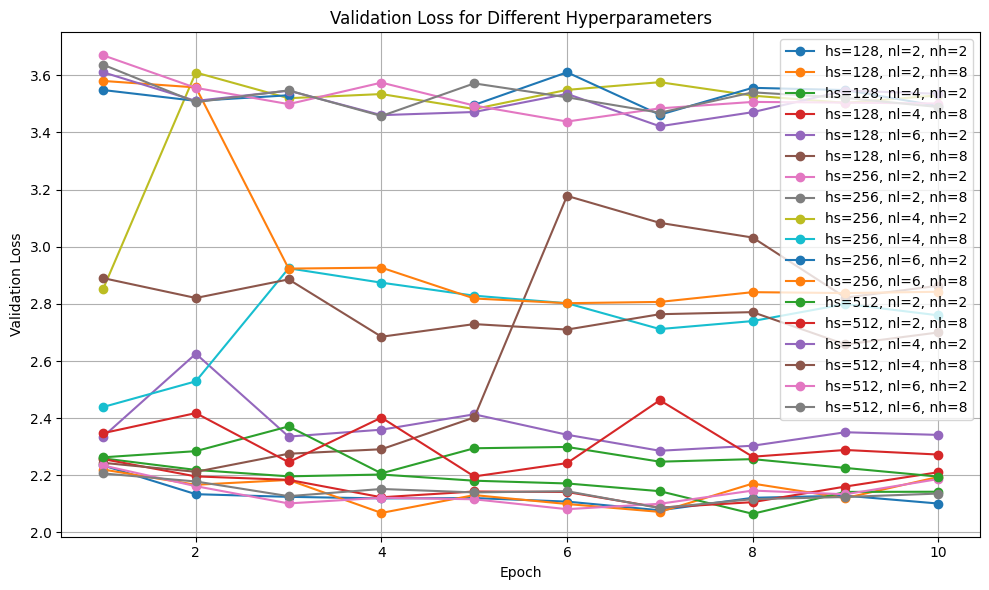

In [3]:
import torch
import itertools
import matplotlib.pyplot as plt

# load in podcast data
data_path = "/ocean/projects/mth240012p/shared/data"
raw_text_path = os.path.join(data_path, "raw_text.pkl")

with open(raw_text_path, "rb") as f:
    raw_text = pickle.load(f)

print(f"Loaded {len(raw_text)} podcast stories")

# flatten all the words from all stories into a single list
all_sentences = []
for story in raw_text.values():
    all_sentences.extend(story.data)

# tokenizer and dataset
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
dataset = TextDataset(all_sentences, tokenizer, max_len=32)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

device = "cuda" if torch.cuda.is_available() else "cpu"

# fixed settings
lr = 3e-4
epochs = 10
intermediate_size = 512

# parameters to tune
hidden_sizes = [128, 256, 512]
num_layers_list = [2, 4, 6]
num_heads_list = [2, 8]

results = {}

# looping over all combinations
for hidden_size, num_layers, num_heads in itertools.product(hidden_sizes, num_layers_list, num_heads_list):
    print(f"Training model with hidden_size={hidden_size}, num_layers={num_layers}, num_heads={num_heads}")

    # create new encoder
    encoder = Encoder(
        vocab_size=tokenizer.vocab_size,
        hidden_size=hidden_size,
        num_heads=num_heads,   
        num_layers=num_layers,
        intermediate_size=intermediate_size,
        max_len=512
    )
    encoder = encoder.to(device)

    # train and get train/val losses
    train_losses, val_losses = train_bert(
        model=encoder,
        dataloader=dataloader,
        tokenizer=tokenizer,
        epochs=epochs,
        lr=lr,
        device=device
    )

    # save losses
    results[(hidden_size, num_layers, num_heads)] = {  
        'train_losses': train_losses,
        'val_losses': val_losses
    }


print("Finished hyperparameter tuning!")


# plot validation loss curves for all runs
plt.figure(figsize=(10, 6))

for (hidden_size, num_layers, num_heads), losses in results.items():
    val_losses = losses['val_losses']
    label = f"hs={hidden_size}, nl={num_layers}, nh={num_heads}"  # <-- add num_heads to label
    plt.plot(range(1, len(val_losses)+1), val_losses, marker='o', label=label)

plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss for Different Hyperparameters')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [4]:
# SAVING BEST ENCODER BY RUNNING IT AGAIN HERE
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

# fixed settings
lr = 3e-4
epochs = 10
batch_size = 32


# build the encoder again with best hyperparameters
encoder = Encoder(
    vocab_size=tokenizer.vocab_size,
    hidden_size=128,     
    num_heads=2,        
    num_layers=2,        
    intermediate_size=intermediate_size,
    max_len=512
)

encoder = encoder.to(device)
dataset = TextDataset(all_sentences, tokenizer, max_len=32)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# train best encoder
print("Training best encoder")
train_losses, val_losses = train_bert(
    model=encoder,
    dataloader=dataloader,
    tokenizer=tokenizer,
    epochs=epochs,
    lr=lr,
    device=device
)

# save this so we can use it in next step
torch.save(encoder.state_dict(), "pretrained_encoder_best.pt")
print("Saved best encoder to pretrained_encoder_best.pt")


Training best encoder
Epoch [1/10], Train Loss: 2.3682, Val Loss: 2.1924
Epoch [2/10], Train Loss: 2.1804, Val Loss: 2.1886
Epoch [3/10], Train Loss: 2.1357, Val Loss: 2.1551
Epoch [4/10], Train Loss: 2.1330, Val Loss: 2.1248
Epoch [5/10], Train Loss: 2.1025, Val Loss: 2.0828
Epoch [6/10], Train Loss: 2.0981, Val Loss: 2.1316
Epoch [7/10], Train Loss: 2.0793, Val Loss: 2.0886
Epoch [8/10], Train Loss: 2.0592, Val Loss: 2.1247
Epoch [9/10], Train Loss: 2.0850, Val Loss: 2.0973
Epoch [10/10], Train Loss: 2.0698, Val Loss: 2.0944
Saved best encoder to pretrained_encoder_best.pt


# Generate All Embeddings 

In [5]:
import torch
import numpy as np
import pickle, os
from transformers import BertTokenizerFast
from encoder import Encoder
from preprocessing import downsample_word_vectors, make_delayed


device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

encoder = Encoder(
    vocab_size=tokenizer.vocab_size,
    hidden_size=128,  # best hyperparameter you found!
    num_heads=4,      # same as you trained
    num_layers=2,     # best hyperparameter you found!
    intermediate_size=512,  # same as training
    max_len=512
)

encoder.load_state_dict(torch.load("pretrained_encoder_best.pt", map_location=device))
encoder.to(device)
encoder.eval()


data_path = "/ocean/projects/mth240012p/shared/data"
with open(os.path.join(data_path, "raw_text.pkl"), "rb") as f:
    raw_text = pickle.load(f)

story_names = list(raw_text.keys())

# step 1: Generate encoder embeddings
encoder_vectors = {}
for story in story_names:
    words = raw_text[story].data
    inputs = tokenizer(words, padding=True, truncation=True, return_tensors="pt", max_length=64)

    input_ids = inputs["input_ids"].to(device)
    token_type_ids = inputs["token_type_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    with torch.no_grad():
        hidden = encoder(input_ids, token_type_ids, attention_mask)

    # Mean over tokens (seq_len)
    sentence_embeddings = hidden.mean(dim=1).cpu().numpy()
    encoder_vectors[story] = sentence_embeddings
    # print(f"{story}: Encoder shape = {encoder_vectors[story].shape}")

# step 2: Downsample
wordseqs = raw_text
downsampled_encoder = downsample_word_vectors(story_names, encoder_vectors, wordseqs)

# step 3: Trim
X_encoder_trimmed = {}
for story in downsampled_encoder:
    X_encoder_trimmed[story] = downsampled_encoder[story][5:-10, :]
    # print(f"Trimmed shape for {story}:", X_encoder_trimmed[story].shape)

# step 4: Create lagged features
X_encoder_lagged = {}
for story in X_encoder_trimmed:
    X_encoder_lagged[story] = make_delayed(X_encoder_trimmed[story], delays=range(1, 5))
    # print(f"Lagged shape for {story}:", X_encoder_lagged[story].shape)


/var/tmp/ipykernel_95437/907037017.py:29: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  raw_text = pickle.load(f)


# Modelling and Evaluation

Missing Y file for: myfirstdaywiththeyankees
Missing Y file for: dialogue6
Missing Y file for: dialogue5
Missing Y file for: dialogue3
Missing Y file for: dialogue2
X_train: (28644, 512)
Y_train: (28644, 94251)

Best alpha found: 10000
Missing Y file for: dialogue1
Missing Y file for: dialogue4
Missing Y file for: onlyonewaytofindout
Mean CC: 0.0060
Median CC: 0.0054
Top 1% CC: 0.0466
Top 5% CC: 0.0318


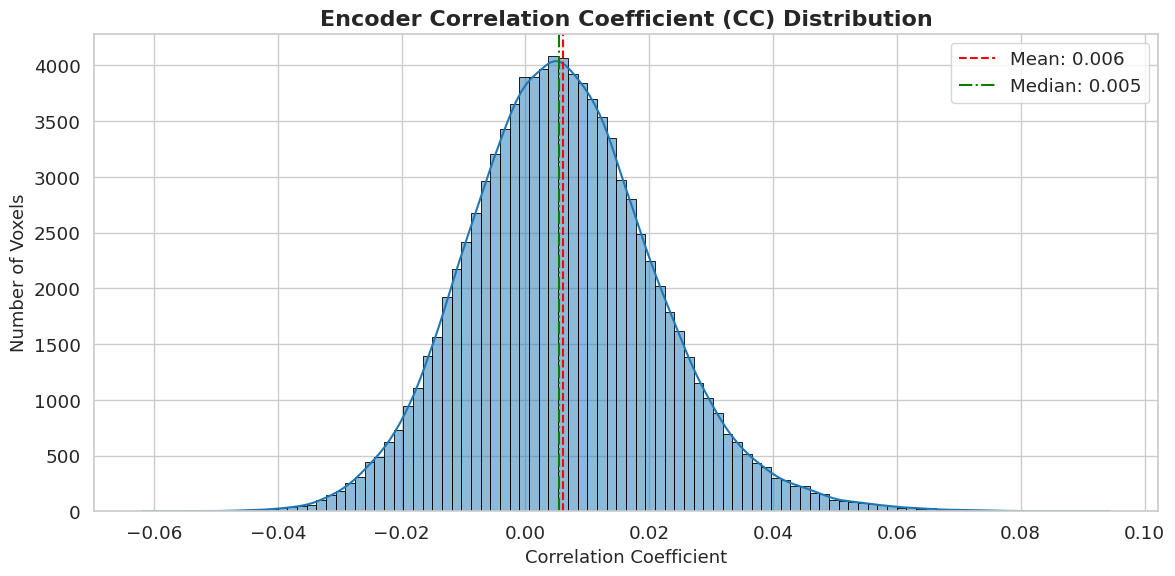

Plot saved to: ../results/cc_distribution__trained_encoder_subject2.png


In [9]:
import numpy as np
import os
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns

# --------- setup ---------
story_names = list(raw_text.keys())
train_stories, test_stories = train_test_split(story_names, test_size=0.2, random_state=42)

subject2_path = os.path.join(data_path, "subject2")
X_train = []
Y_train = []



for story in train_stories:
    if story in X_encoder_lagged:
        bold_path = os.path.join(subject2_path, f"{story}.npy")
        if os.path.exists(bold_path):
            Y = np.load(bold_path)
            X = X_encoder_lagged[story]
            min_len = min(X.shape[0], Y.shape[0])
            X_train.append(X[:min_len])
            Y_train.append(Y[:min_len])
        else:
            print(f"Missing Y file for: {story}")

X_train = np.vstack(X_train)
Y_train = np.vstack(Y_train)
print("X_train:", X_train.shape)
print("Y_train:", Y_train.shape)

# --------- clean NaNs ---------
mask = ~np.isnan(Y_train).any(axis=1)
X_train_clean = X_train[mask]
Y_train_clean = Y_train[mask]

# --------- cross validation ---------
sample_size = int(0.1 * X_train_clean.shape[0])  # 10% of the data
X_train_sub = X_train_clean[:sample_size]
Y_train_sub = Y_train_clean[:sample_size] 
alphas = [1, 10, 100, 1000, 10000] 
ridge = Ridge()
grid_search = GridSearchCV(
    ridge,
    param_grid={'alpha': alphas},
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1  # (optional, speeds it up if you want)
)
grid_search.fit(X_train_sub, Y_train_sub)
best_alpha = grid_search.best_params_['alpha']
print(f"\nBest alpha found: {best_alpha}")

# --------- train model ---------
ridge_best = Ridge(alpha=best_alpha)
ridge_best.fit(X_train_clean, Y_train_clean)

# --------- evaluate on test set ---------
X_test = []
Y_test = []

for story in test_stories:
    if story in X_encoder_lagged:
        bold_path = os.path.join(subject2_path, f"{story}.npy")
        if os.path.exists(bold_path):
            Y = np.load(bold_path)
            X = X_encoder_lagged[story]
            min_len = min(X.shape[0], Y.shape[0])
            X_test.append(X[:min_len])
            Y_test.append(Y[:min_len])
        else:
            print(f"Missing Y file for: {story}")

X_test = np.vstack(X_test)
Y_test = np.vstack(Y_test)

# Clean NaNs from test
mask = ~np.isnan(Y_test).any(axis=1)
X_test_clean = X_test[mask]
Y_test_clean = Y_test[mask]

# predict
Y_pred = ridge_best.predict(X_test_clean)

# --------- compute correlation coefficients (CCs) ---------
def compute_voxel_ccs(y_true, y_pred):
    ccs = []
    for i in range(y_true.shape[1]):
        try:
            cc, _ = pearsonr(y_true[:, i], y_pred[:, i])
        except:
            cc = np.nan
        ccs.append(cc)
    return np.array(ccs)

ccs_encoder = compute_voxel_ccs(Y_test_clean, Y_pred)

print(f"Mean CC: {np.mean(ccs_encoder):.4f}")
print(f"Median CC: {np.median(ccs_encoder):.4f}")
print(f"Top 1% CC: {np.percentile(ccs_encoder, 99):.4f}")
print(f"Top 5% CC: {np.percentile(ccs_encoder, 95):.4f}")

# --------- visualization ---------
sns.set(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(12, 6))

sns.histplot(ccs_encoder[~np.isnan(ccs_encoder)], bins=100, kde=True, color="#1f77b4", edgecolor="black", stat="count")
plt.axvline(np.mean(ccs_encoder), color='red', linestyle='--', label=f"Mean: {np.mean(ccs_encoder):.3f}")
plt.axvline(np.median(ccs_encoder), color='green', linestyle='-.', label=f"Median: {np.median(ccs_encoder):.3f}")
plt.title("Encoder Correlation Coefficient (CC) Distribution", fontsize=16, weight="bold")
plt.xlabel("Correlation Coefficient", fontsize=13)
plt.ylabel("Number of Voxels", fontsize=13)
plt.legend()
plt.tight_layout()

# save plot
save_dir = os.path.join("..", "results")
os.makedirs(save_dir, exist_ok=True)
plot_path = os.path.join(save_dir, "cc_distribution__trained_encoder_subject2.png")
plt.savefig(plot_path, dpi=300)
plt.show()

print(f"Plot saved to: {plot_path}")


# Stability Check

In [10]:
# ----- stability check -----
# perform the differences between different stories
ccs_per_story = []

for story in test_stories:
    if story in X_encoder_lagged:
        X_test_story = X_encoder_lagged[story]
        bold_path = os.path.join(subject2_path, f"{story}.npy")

        if os.path.exists(bold_path):
            Y_test_story = np.load(bold_path)
            min_len = min(X_test_story.shape[0], Y_test_story.shape[0])
            X_test_story = X_test_story[:min_len]
            Y_test_story = Y_test_story[:min_len]
            Y_pred_story = ridge_best.predict(X_test_story)
            ccs_story = compute_voxel_ccs(Y_test_story, Y_pred_story)
            ccs_per_story.append(ccs_story)
        else:
            print(f"Warning: {bold_path} not found, skipping this story.")

# combine all sotries
ccs_per_story = np.array(ccs_per_story)

/var/tmp/ipykernel_95437/3410843235.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("plasma")  # You could also try "plasma", "coolwarm", "turbo", etc.


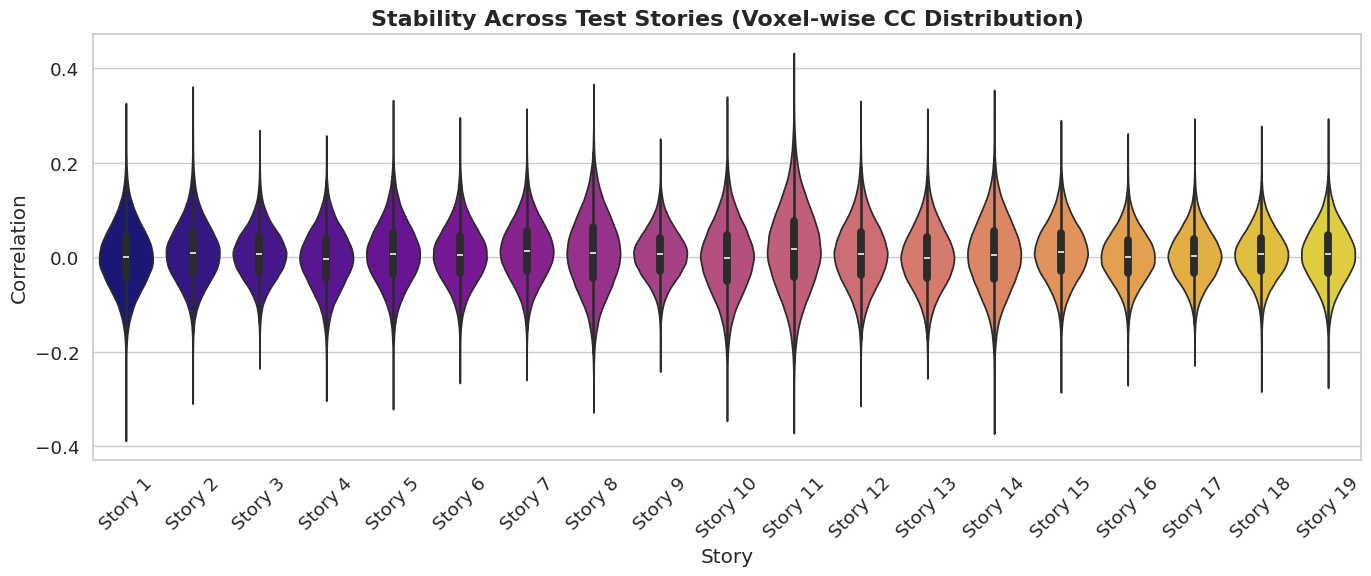

In [11]:
# ----- visualization -----
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.cm import get_cmap

all_ccs = []
story_labels = []

for i, ccs_story in enumerate(ccs_per_story):
    all_ccs.extend(ccs_story)
    story_labels.extend([f"Story {i+1}"] * len(ccs_story))

df = pd.DataFrame({
    'Correlation': all_ccs,
    'Story': story_labels
    
})

num_stories = len(ccs_per_story)
cmap = get_cmap("plasma")  # You could also try "plasma", "coolwarm", "turbo", etc.
colors = [cmap(i / num_stories) for i in range(num_stories)]
story_names = [f"Story {i+1}" for i in range(num_stories)]
palette = dict(zip(story_names, colors))

plt.figure(figsize=(14, 6))
sns.violinplot(
    x='Story',
    y='Correlation',
    hue='Story',
    data=df,
    inner="box",
    palette=palette,
    legend=False  
)
plt.title("Stability Across Test Stories (Voxel-wise CC Distribution)", fontsize=16, weight="bold")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../results/cc_violin_plot_stability.png", dpi=300)
plt.show()